## 1. Imports

In [1]:
# OS
import os
# Pretty Printer
from pprint import pprint
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
# Models
from model import healthy_model, covid_model, save_checkpoint

## 2. Setup

Set device

In [2]:
device = "cuda"

The dataset has been split into training, validation, and testing sets, containing multiple non-identical pictures

In [3]:
groups = ['train', 'val', 'test']
pprint(groups)

['train', 'val', 'test']


The images in the dataset are X-ray pictures of either infected lungs (class index 1 and label 'infected') or non-infected lungs (class index 0 and label 'normal'). We will use this classification for our first binary classifier (normal or infected lungs) and we call this the Initial Model.

For images in the infected sub-dataset, X-ray pictures can either be of COVID-infected lungs (class index 0 and label 'covid') or any other infected lungs (class index 1 and label 'non_covid'). We will use this classificatino for our second binary classifier (COVID or Non-Covid infected lungs) and we call this the Infected Model.

For testing, we will use the combined classes to classify the X-ray pictures. We first input the image into the Initial Model. If the output label is 'normal', we don't need to pass this image into our Infected Model. However, if the output label is 'infected', we pass this image into the Infected Model to further classify whether it is infected by COVID or non_covid.

In [4]:
initial_classes = {0: "normal", 1: "infected"}
infected_classes = {0: "covid", 1: "non_covid"}
combined_classes = {0: "normal", 1: "covid", 2: "non_covid"}
print("Initial Model classes: {}\n".format(initial_classes))
print("Infected Model classes: {}\n".format(infected_classes))
print("Combined Model classes: {}\n".format(combined_classes))

Initial Model classes: {0: 'normal', 1: 'infected'}

Infected Model classes: {0: 'covid', 1: 'non_covid'}

Combined Model classes: {0: 'normal', 1: 'covid', 2: 'non_covid'}



Each subset is stored in a different subfolder of the **./dataset/** folder, as listed in the dictionary below:

In [5]:
# Path to images for different parts of the dataset
dataset_paths = {'train_normal': './dataset/train/normal/',
                 'train_infected_covid': './dataset/train/infected/covid',
                 'train_infected_non_covid': './dataset/train/infected/non-covid',
                 'val_normal': './dataset/val/normal/',
                 'val_infected_covid': './dataset/val/infected/covid',
                 'val_infected_non_covid': './dataset/val/infected/non-covid',
                 'test_normal': './dataset/test/normal/',
                 'test_infected_covid': './dataset/test/infected/covid',
                 'test_infected_non_covid': './dataset/test/infected/non-covid'}
pprint(dataset_paths)

{'test_infected_covid': './dataset/test/infected/covid',
 'test_infected_non_covid': './dataset/test/infected/non-covid',
 'test_normal': './dataset/test/normal/',
 'train_infected_covid': './dataset/train/infected/covid',
 'train_infected_non_covid': './dataset/train/infected/non-covid',
 'train_normal': './dataset/train/normal/',
 'val_infected_covid': './dataset/val/infected/covid',
 'val_infected_non_covid': './dataset/val/infected/non-covid',
 'val_normal': './dataset/val/normal/'}


We can count the numbers of samples (X-ray pictures) inside each of the subfolders and store them in a dictionary ***dataset_numbers***. Note that an infected lung means it is infected by either COVID or other non-COVID diseases, thus we also calculate a tally of infected X-ray lung images (COVID infected + non-COVID infected). This will be useful for our binary classifier later that classifies either a normal lung (non-infected) or an infected lung.

In [6]:
dataset_numbers = {}

for key, value in dataset_paths.items():
    dataset_numbers[key] = len(os.listdir(value))

for group in groups:
    dataset_numbers["{}_infected".format(group)] = dataset_numbers['{}_infected_covid'.format(group)] + dataset_numbers['{}_infected_non_covid'.format(group)]
    dataset_numbers["{}_total".format(group)] = dataset_numbers["{}_infected".format(group)] + dataset_numbers["{}_normal".format(group)]

pprint(dataset_numbers)

{'test_infected': 381,
 'test_infected_covid': 139,
 'test_infected_non_covid': 242,
 'test_normal': 234,
 'test_total': 615,
 'train_infected': 3875,
 'train_infected_covid': 1345,
 'train_infected_non_covid': 2530,
 'train_normal': 1341,
 'train_total': 5216,
 'val_infected': 17,
 'val_infected_covid': 9,
 'val_infected_non_covid': 8,
 'val_normal': 8,
 'val_total': 25}


A helper function to get relevant attributes from the dataset. The attribute can only be dataset_numbers or dataset_paths, while the group can only be 'train', 'val', or 'test'.

In [7]:
attributes = [dataset_numbers, dataset_paths]

def get_dataset_attributes(group, attribute, infected_only = False):
    assert group in groups, "Invalid group input. Group can only be 'train', 'val', or 'test'"
    assert attribute in attributes, "Invalid attribute. Attribute can only be dataset_numbers or dataset_paths"
    res = {}
    for key, value in attribute.items():
        if group in key:
            if not infected_only:
                res[key] = value
            elif 'infected' in key:
                res[key] = value
    return res

## 3. Create a Dataset Generator that is reusable to generate Training Dataset and Validating Dataset of Initial Model (First Binary Classifier).

The Dataset generated will contain two special methods, which need to be defined if we want to transform our Dataset object into a dataloader later on.

The first method is the special length method ( __ len __ ), which should return the number of images present in the dataset. We can easily obtain this from ```dataset_numbers[{SELECTED_GROUP}_total]``` (e.g. ```dataset_numbers[train_total]``` or ```dataset_numbers[val_total]```.

The second one is the special getitem method ( __ getitem __ ), which is used to fetch an image and its label, using a single index value.

By convention here, we have decided to open the image in ```./dataset/{SELECTED_GROUP}/normal/XXX.jpg```, if the value in XXX is strictly lower than the total number of normal lung images in the selected group's dataset.

Otherwise, we will open the image somewhere in ```./dataset/{SELECTED_GROUP}/infected/```. Again, by convention, we will open the image in ```./dataset_demo/{SELECTED_GROUP}/infected/covid/YYY.jpg``` if YYY is strictly lower than ```(total COVID images) - XXX```.

Otherwise, we open the image in ```./dataset/{SELECTED_GROUP}/infected/non-covid/ZZZ.jpg```, where ZZZ is simply defined as ZZZ = YYY - total COVID images.

For example, let's say we supply ***__getitem__*** with ***index*** = **5000** in the **Training Dataset**. There are 1341 images of normal lungs in ```./dataset/train/normal/```. Since 5000 > 1341, we will have to open the image somewhere in ```./dataset/train/infected/```.

There are 1345 images of COVID-infected lungs in ```./dataset_demo/train/infected/covid/```. Since 5000 - 1341 > 1345, this means we will have to take the image from ```./dataset_demo/train/infected/non-covid/```. We will thus take image with index 5000 - 1341 - 1345 = **2314.jpg** in ```./dataset_demo/train/infected/non-covid/```.

Note that if the value in XXX is larger than the length of the dataset (i.e. 5216 - 1 = 5215), then no image will be opened and the getitem will display an error, based on the asserts we have in the ***open_img*** method.

In [8]:
class Lung_Dataset(Dataset):
    
    def __init__(self, group):
        """
        Construtor for Training Dataset class
        Picks important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = initial_classes
        
        # The dataset consists only of images from the specified group
        self.groups = group
        
        # Total Aggregator
        self.aggregator = "total"
        
        # Number of images in each part
        self.dataset_numbers = get_dataset_attributes(group, dataset_numbers)
        
        # Path to images for different parts of the dataset
        self.dataset_paths = get_dataset_attributes(group, dataset_paths)
    
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the {}ing dataset derived from the Lung Dataset".format('validat' if self.groups == 'val' else self.groups)
        msg += " used for the Small Project in the 50.039 Deep Learning class"
        msg += " in Feb - March 2021.\n"
        msg += "It contains a total of {} images, ".format(self.dataset_numbers["{}_{}".format(self.groups, self.aggregator)])
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, value in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, value, self.dataset_numbers[key])
        print(msg)
        
    def open_img(self, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(self.groups, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(self.groups, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val < max_val, err_msg
        
        # Open file as before
        covid_total = dataset_numbers['{}_infected_covid'.format(self.groups)]
        if class_val == 'infected' and index_val < covid_total:
            path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_infected_covid'.format(self.groups)], index_val)
        elif class_val == 'infected':
            path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_infected_non_covid'.format(self.groups)], index_val - covid_total)
        else:
            path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_normal'.format(self.groups)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    def show_img(self, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(class_val, index_val)
        
        # Display
        plt.imshow(im)
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return self.dataset_numbers['{}_{}'.format(self.groups, self.aggregator)]
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        normal_total = self.dataset_numbers["{}_normal".format(self.groups)]
        if index < normal_total:
            class_val = 'normal'
            label = torch.tensor(0, dtype = torch.long, device = device)
        else:
            class_val = 'infected'
            index -= normal_total
            label = torch.tensor(1, dtype = torch.long, device = device)
        im = self.open_img(class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

Create **Training Dataset** (for Initial Model)

In [9]:
ld_train = Lung_Dataset('train')
ld_train.describe()

This is the training dataset derived from the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb - March 2021.
It contains a total of 5216 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_infected_covid, in folder ./dataset/train/infected/covid: 1345 images.
 - train_infected_non_covid, in folder ./dataset/train/infected/non-covid: 2530 images.



Create **Testing Dataset** (for Initial Model)

In [10]:
ld_test = Lung_Dataset('test')
ld_test.describe()

This is the testing dataset derived from the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb - March 2021.
It contains a total of 615 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - test_normal, in folder ./dataset/test/normal/: 234 images.
 - test_infected_covid, in folder ./dataset/test/infected/covid: 139 images.
 - test_infected_non_covid, in folder ./dataset/test/infected/non-covid: 242 images.



## 4. Create an Infected Dataset Generator to generate Infected Dataset for training and validation of Infected Model (Second Binary Classifier).

In [11]:
class Infected_Lung_Dataset(Lung_Dataset):
    
    def __init__(self, group):
        """
        Construtor for Training Dataset class
        Picks important parameters in attributes.
        """        
        super().__init__(group)
        
        # Only two classes will be considered here (covid and non-covid)
        self.classes = infected_classes
        
        # Total Aggregator
        self.aggregator = 'infected'
        
        # Number of images in each part
        self.dataset_numbers = get_dataset_attributes(group, dataset_numbers, infected_only = True)
        
        # Path to images for different parts of the dataset
        self.dataset_paths = get_dataset_attributes(group, dataset_paths, infected_only = True)
        
    def open_img(self, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - class_val variable should be set to 'covid' or 'non_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters        
        err_msg = "Error - class_val variable should be set to 'covid' or 'non-covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_infected_{}'.format(self.groups, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/infected/{}, you have {} images.)".format(self.groups, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val < max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_infected_{}'.format(self.groups, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        covid_total = self.dataset_numbers["{}_infected_covid".format(self.groups)]
        if index < covid_total:
            class_val = 'covid'
            label = torch.tensor(0, dtype = torch.long, device = device)
        else:
            class_val = 'non_covid'
            index -= covid_total
            label = torch.tensor(1, dtype = torch.long, device = device)
        im = self.open_img(class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

Create **Infected Training Dataset** (for Infected Model)

In [12]:
ld_train_infected = Infected_Lung_Dataset('train')
ld_train_infected.describe()

This is the training dataset derived from the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb - March 2021.
It contains a total of 3875 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_infected_covid, in folder ./dataset/train/infected/covid: 1345 images.
 - train_infected_non_covid, in folder ./dataset/train/infected/non-covid: 2530 images.



Create **Infected Testing Dataset** (for Infected Model)

In [13]:
ld_test_infected = Infected_Lung_Dataset('test')
ld_test_infected.describe()

This is the testing dataset derived from the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb - March 2021.
It contains a total of 381 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - test_infected_covid, in folder ./dataset/test/infected/covid: 139 images.
 - test_infected_non_covid, in folder ./dataset/test/infected/non-covid: 242 images.



## 5. Create Testing Dataset

In [14]:
class Test_Lung_Dataset(Lung_Dataset):
    
    def __init__(self):
        """
        Construtor for Training Dataset class
        Picks important parameters in attributes.
        """
        super().__init__('val')
        
        # Use combined classes (0 for normal, 1 for COVID, 2 for infected by non-COVID)
        self.classes = combined_classes
        
    def open_img(self, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - class_val variable should be set to 'normal' or 'covid' or 'non_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters        
        err_msg = "Error - class_val variable should be set to 'normal' or 'covid' or 'non_covid'."
        assert class_val in self.classes.values(), err_msg
        
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        if 'covid' in class_val:
            max_val = self.dataset_numbers['val_infected_{}'.format(class_val)]
            err_msg += "\n(In test/infected/{}, you have {} images.)".format(class_val, max_val)
        else:
            max_val = self.dataset_numbers['val_normal']
            err_msg += "\n(In test/normal, you have {} images.)".format(max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val < max_val, err_msg
        
        # Open file as before
        if 'covid' in class_val:
            path_to_file = '{}/{}.jpg'.format(self.dataset_paths['val_infected_{}'.format(class_val)], index_val)
        else:
            path_to_file = '{}/{}.jpg'.format(self.dataset_paths['val_normal'], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        normal_total = self.dataset_numbers["val_normal"]
        covid_total = self.dataset_numbers["val_infected_covid"]
        if index < normal_total:
            class_val = 'normal'
            label = torch.tensor(0, dtype = torch.long, device = device)
        else:
            index -= normal_total
            if index < covid_total:
                class_val = "covid"
                label = torch.tensor(1, dtype = torch.long, device = device)
            else:
                class_val = "non_covid"
                index -= covid_total
                label = torch.tensor(2, dtype = torch.long, device = device)
        im = self.open_img(class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [15]:
ld_test_final = Test_Lung_Dataset()
ld_test_final.describe()

This is the validating dataset derived from the Lung Dataset used for the Small Project in the 50.039 Deep Learning class in Feb - March 2021.
It contains a total of 25 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - val_normal, in folder ./dataset/val/normal/: 8 images.
 - val_infected_covid, in folder ./dataset/val/infected/covid: 9 images.
 - val_infected_non_covid, in folder ./dataset/val/infected/non-covid: 8 images.



## 6. Visualization of the image distribution in the dataset:

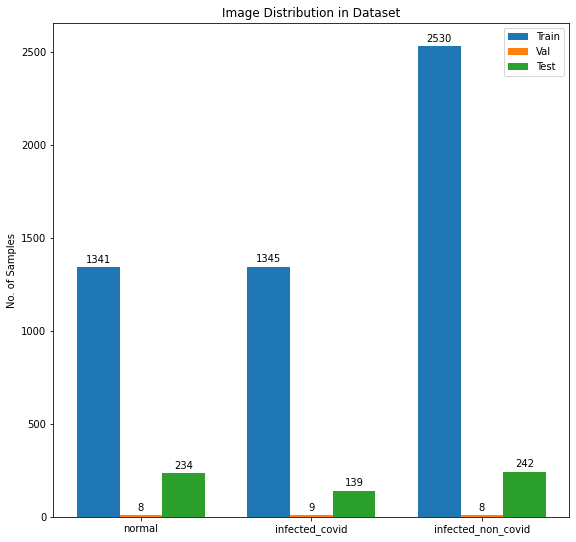

In [16]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

labels = ["normal", "infected_covid", "infected_non_covid"]
train_bar_values = [dataset_numbers["train_normal"], dataset_numbers["train_infected_covid"], dataset_numbers["train_infected_non_covid"]]
val_bar_values = [dataset_numbers["val_normal"], dataset_numbers["val_infected_covid"], dataset_numbers["val_infected_non_covid"]]
test_bar_values = [dataset_numbers["test_normal"], dataset_numbers["test_infected_covid"], dataset_numbers["test_infected_non_covid"]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_bar_values, width, label='Train')
rects2 = ax.bar(x, val_bar_values, width, label='Val')
rects3 = ax.bar(x + width, test_bar_values, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No. of Samples')
ax.set_title('Image Distribution in Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
fig.set_size_inches(8.5, 8.5)

plt.show()

## 7. Create the Dataloaders

In [17]:
# Batch size value to be used
bs_val = 16

In [18]:
# Dataloader for Training and Validation Datasets of Initial Model (First Binary Classifier)
first_train_loader = DataLoader(ld_train, batch_size = bs_val, shuffle = True)
first_test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
print(first_train_loader)
print(first_test_loader)

In [19]:
# Dataloader for Training and Validation Datasets of Infected Model (Second Binary Classifier)
infected_train_loader = DataLoader(ld_train_infected, batch_size = bs_val, shuffle = True)
infected_test_loader = DataLoader(ld_test_infected, batch_size = bs_val, shuffle = True)
print(infected_train_loader)
print(infected_test_loader)

In [20]:
# Dataloader for Testing Dataset
test_loader = DataLoader(ld_test_final, batch_size = bs_val, shuffle = True)
print(test_loader)

## 8. RYAN PART

In [ ]:
# Set the parameters
hidden_units = 1024
epochs = 5
learning_rate = 0.001
model_name = "custom"
save_dir = False

for layer in range(3,8):
    print("Running models with {} convolutional layers".format(layer))
    print("==============================\n")
    print("Running Initial Model")
    initial_model = healthy_model(n_hidden=[hidden_units], n_epoch=epochs, labelsdict=initial_classes, lr=learning_rate, device=device, \
                    model_name=model_name, trainloader=first_train_loader, validloader=first_test_loader, train_data=ld_train, layers=layer)
    print("Running Infected Model")
    infected_model = covid_model(n_hidden=[hidden_units], n_epoch=epochs, labelsdict=infected_classes, lr=learning_rate, device=device, \
                    model_name=model_name, trainloader=infected_train_loader, validloader=infected_test_loader, train_data=ld_train_infected, layers=layer)

if save_dir:
    save_checkpoint(model, save_dir)

Running models with 3 convolutional layers

Running Initial Model
Net(
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=663552, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)
model is training
Accuracy: 0.9375
Train Epoch: 1 [0/5216 (0%)]	Loss: 0.633503
Accuracy: 0.875
Train Epoch: 1 [256/5216 (5%)]	Loss: 0.429678
Accuracy: 0.6875
Train Epoch: 1 [512/5216 (10%)]	Loss: 0.702579
Accuracy: 0.8125
Train Epoch: 1 [768/5216 (15%)]	Loss: 0.629397
Accuracy: 0.5
Train Epoch: 1 [1024/5216 (20%)]	Loss: 0.732019
Accuracy: 0.75
Train Epoch: 1 [1280/5216 (25%)]	Loss: 0.505293
Accuracy: 0.75
Train Epoch: 1 [1536/5216 (29%)]	Loss: 0.635109
Accuracy: 0.75
Train Epoch: 1 [1792/5216 (34%)]	Loss: 0.646339
Accuracy: 0.5
Train Epoch: 1 [2048/5216 (39%)]	Loss: 0.862293
Accuracy: 1.0
Train Epoch: 1 [2304/5216 (44%)]	Loss: 0.246883
Ac

Accuracy: 0.75
Train Epoch: 1 [2048/3875 (53%)]	Loss: 0.556354
Accuracy: 0.9375
Train Epoch: 1 [2304/3875 (59%)]	Loss: 0.191511
Accuracy: 0.625
Train Epoch: 1 [2560/3875 (66%)]	Loss: 0.754885
Accuracy: 0.75
Train Epoch: 1 [2816/3875 (72%)]	Loss: 0.528874
Accuracy: 0.8125
Train Epoch: 1 [3072/3875 (79%)]	Loss: 0.731795
Accuracy: 0.8125
Train Epoch: 1 [3328/3875 (86%)]	Loss: 0.492734
Accuracy: 0.8125
Train Epoch: 1 [3584/3875 (92%)]	Loss: 0.434571
Accuracy: 0.625
Train Epoch: 1 [3840/3875 (99%)]	Loss: 1.042656

Epoch 1 Validation set: Average loss: 0.0151, Accuracy: 332/381 (87%)

model is training
Accuracy: 0.875
Train Epoch: 2 [0/3875 (0%)]	Loss: 0.280990
Accuracy: 0.9375
Train Epoch: 2 [256/3875 (7%)]	Loss: 0.164306
Accuracy: 0.75
Train Epoch: 2 [512/3875 (13%)]	Loss: 0.719353
Accuracy: 0.6875
Train Epoch: 2 [768/3875 (20%)]	Loss: 0.882683
Accuracy: 0.75
Train Epoch: 2 [1024/3875 (26%)]	Loss: 0.420361
Accuracy: 0.75
Train Epoch: 2 [1280/3875 (33%)]	Loss: 1.320678
Accuracy: 0.625
Train

Train Epoch: 3 [0/5216 (0%)]	Loss: 0.493609
Accuracy: 0.8125
Train Epoch: 3 [256/5216 (5%)]	Loss: 0.508908
Accuracy: 0.9375
Train Epoch: 3 [512/5216 (10%)]	Loss: 0.354097
Accuracy: 0.875
Train Epoch: 3 [768/5216 (15%)]	Loss: 0.487352
Accuracy: 0.8125
Train Epoch: 3 [1024/5216 (20%)]	Loss: 0.404245
Accuracy: 0.5625
Train Epoch: 3 [1280/5216 (25%)]	Loss: 0.618143
Accuracy: 0.75
Train Epoch: 3 [1536/5216 (29%)]	Loss: 0.435599
Accuracy: 0.875
Train Epoch: 3 [1792/5216 (34%)]	Loss: 0.341731
Accuracy: 0.6875
Train Epoch: 3 [2048/5216 (39%)]	Loss: 0.456525
Accuracy: 0.875
Train Epoch: 3 [2304/5216 (44%)]	Loss: 0.427763
Accuracy: 0.8125
Train Epoch: 3 [2560/5216 (49%)]	Loss: 0.457158
Accuracy: 0.875
Train Epoch: 3 [2816/5216 (54%)]	Loss: 0.409349
Accuracy: 0.8125
Train Epoch: 3 [3072/5216 (59%)]	Loss: 0.509116
Accuracy: 0.8125
Train Epoch: 3 [3328/5216 (64%)]	Loss: 0.480765
Accuracy: 0.875
Train Epoch: 3 [3584/5216 (69%)]	Loss: 0.348157
Accuracy: 0.625
Train Epoch: 3 [3840/5216 (74%)]	Loss: 0.

In [ ]:
from numpy import load
import matplotlib.pyplot as plt
import numpy as np
loss_vals = load('health.npy')
print(loss_vals)

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
fig.set_figheight(8)
fig.set_figwidth(20)
print(loss_vals.shape)
p = np.arange(1,loss_vals.shape[0]+1,1)
plt.plot(p,loss_vals,linewidth=3)

plt.show()

In [ ]:
from numpy import load
import matplotlib.pyplot as plt
import numpy as np
loss_vals = load('covid.npy')
print(loss_vals)

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
fig.set_figheight(8)
fig.set_figwidth(20)
print(loss_vals.shape)
p = np.arange(1,loss_vals.shape[0]+1,1)
plt.plot(p,loss_vals,linewidth=3)

plt.show()

In [ ]:
import sklearn
def validationTest(modelhealthy, modelcovid, device, valid_loader):
    modelhealthy.eval()
    modelcovid.eval()
    valid_loss = 0
    TP1 = 0
    TP2 = 0
    TN1 = 0
    TN2 = 0
    FP1 = 0
    FP2 = 0
    FN1 = 0
    FN2 = 0
    label_list = []
    pre_list = []
    print_list = []
    final_output = torch.Tensor([])
    healthy_img = []
    covid_img = []
    no_covid_img = []
    with torch.no_grad():
        # Loop over all examples in test set
        for image, label in test_loader:

            # Send the data and label to the device
            image, label = image.to(device), label.to(device)

            # Pass the image through the model
            output = modelhealthy(image)
            # Get the index of the max log-probability
            init_pred = output.max(1, keepdim = True)[1]
            print(init_pred)

            if init_pred == 1:
                output2 = modelcovid(image)
                init_pred = output.max(1,keepdim=True)[1]
            image_ex = image.squeeze().detach().cpu().numpy()
            pre_list.append(init_pred)
            label_list.append(target2.view_as(pred2))
            print_list.append([image_ex,label,init_pred])
        print(multilabel_confusion_matrix(label_list, pre_list, labels=[0,1,2]))
    
    return print_list

printlist = validationTest(initial_model, infected_model, device, ld_test_final)

In [ ]:
plt.figure(figsize = (10, 10))
plt.suptitle('Validation set images with target and predictions \n accuracy{},TN{},FN{}'.format('remembertosetthis',2,3), fontsize=10)
# Browse through epsilon values and adversarial examples

for j in range(len(printlist)):
    cnt += 1
    plt.subplot(6, 4, cnt)

    # Remove x-axis and y-axis ticks from plot
    plt.xticks([], [])
    plt.yticks([], [])

    # set title for plot

    # Labels for each image subplot
    picture, target, pred = printlist[j]
    plt.title("Ground Truth Label{} -> Predicted Label{}".format(target, pred))

    # Display image
    plt.imshow(picture)
        
# Display full plot
plt.tight_layout()
plt.show()